# Vector Space Semantics for Similarity between Eastenders Characters

In this project, you will be creating a vector representation of a document containing lines spoken by a character in the Eastenders script data (i.e. from the file `training.csv`), then improving that representation such that each character vector is maximially distinguished from the other character documents. This distinction is measured by how well a simple information retrieval classification method can select documents from validation and test data as belonging to the correct class of document (i.e. deciding which character spoke the lines by measuring the similarity of those character document vectors to those built in training).

The first 400 lines of each character in the training data training.csv is used to create the training documents, and a maximum of the first 40 lines in the test data (from test.csv).

In [ ]:
!pip install nltk

Importing Libraries

In [ ]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import nltk

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier


from nltk import ngrams
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import sent_tokenize
nltk.download('averaged_perceptron_tagger')

%matplotlib inline
pd.options.display.max_colwidth=500

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Loading the data

In [ ]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
all_train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
all_train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE
...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE


Split into training and test data for heldout validation with random samples of 9:1 train/heldout split

In [ ]:
from random import shuffle, seed

seed(0) # set a seed for reproducibility so same split is used each time

epsiode_scene_column = all_train_data.Episode.astype(str) + "-" + all_train_data.Scene.astype(str)
all_train_data['episode_scene'] = epsiode_scene_column
episode_scenes = sorted(list(set([x for x in epsiode_scene_column.values]))) # need to sort to ensure same initial order

shuffle(episode_scenes)

print(len(episode_scenes))
episode_split = int(0.9*len(episode_scenes))
training_ep_scenes = episode_scenes[:episode_split]
test_ep_scenes = episode_scenes[episode_split:]
print(len(training_ep_scenes), len(test_ep_scenes))

def train_or_heldout_eps(val):
    if val in training_ep_scenes:
        return "training"
    return "heldout"

all_train_data['train_heldout'] = all_train_data['episode_scene'].apply(train_or_heldout_eps)

1394
1254 140


In [ ]:
print('Raw Data: ',np.shape(all_train_data))
train_data = all_train_data[all_train_data['train_heldout']=='training']
val_data = all_train_data[all_train_data['train_heldout']=='heldout']
print('Train set: ',np.shape(train_data))
print('Validation set: ',np.shape(val_data))

Raw Data:  (15319, 8)
Train set:  (13638, 8)
Validation set:  (1681, 8)


In [ ]:
train_data

,Episode,Scene,Scene_info,Character_name,Line,Gender,episode_scene,train_heldout
0,1350,1,DESERTED CAR PARK EXT NIGHT,SHIRLEY,"Look at ya, not a mark on ya. And you think you're an unlucky man.",FEMALE,1350-1,training
1,1350,1,DESERTED CAR PARK EXT NIGHT,OTHER,Shirl...,MALE,1350-1,training
2,1350,2,R&R INT NIGHT,JACK,Oi. Where have you been? Huh? What were the texts about?,MALE,1350-2,training
3,1350,2,R&R INT NIGHT,RONNIE,Nothing. Nothing. I'll be with you in two minutes yeah?,FEMALE,1350-2,training
4,1350,2,R&R INT NIGHT,JACK,"Well I've got mates here I wanted to have a chat with them, instead I've been serving behind the bar.",MALE,1350-2,training
...,...,...,...,...,...,...,...,...
15314,1399,55,SQUARE EXT DAY LIGHT,OTHER,"Dad? Okay ... alright, just one drink alright. But that's all. It doesn't mean anything. It's just a drink.",MALE,1399-55,training
15315,1399,55,SQUARE EXT DAY LIGHT,MAX,Thanks Bradley. Thanks mate... It means the world to me...,MALE,1399-55,training
15316,1399,55,SQUARE EXT DAY LIGHT,OTHER,You alright...,MALE,1399-55,training
15317,1399,55,SQUARE EXT DAY LIGHT,MAX,"Yeah, yeah, yeah. I'm fine.",MALE,1399-55,training


In [ ]:
if False:
    # A simpler alternative to the above, but where a high split means some characters
    print('Raw Data: ',np.shape(all_train_data))
    idx = int(0.9 * np.shape(all_train_data)[0])
    train_data = all_train_data[:idx]
    val_data = all_train_data[idx:]
    print('Train set: ',np.shape(train_data))
    print('Validation set: ',np.shape(val_data))

In [ ]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them.
    
    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    df_metadata = df.groupby([df.Character_name,df.Episode, df.Scene]) 
    for (char_name, Episode, Scene) in df_metadata.groups.keys():
        df_required = df.loc[(df['Episode'] == Episode) & (df['Scene'] == Scene)]
        lines = ""
        for line in df_required.Line:
            lines +=str(line)        
        if not char_name in character_docs.keys():
            character_docs[char_name] = ""
            character_line_count[char_name] = 0  
        if character_line_count[char_name] == max_line_count:
            continue
        info = df_required['Scene_info'].values[0]    
        character_docs[char_name] += str(lines) + "_EOL_" + info + " _EOL_ "  # adding an end-of-line token
        character_line_count[char_name]+=1
    print("lines per character", character_line_count)
    return character_docs

In [ ]:
# print out the number of words each character has in the training set
# only use the first 360 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=360)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'CHRISTIAN': 83, 'CLARE': 92, 'HEATHER': 101, 'IAN': 169, 'JACK': 121, 'JANE': 143, 'MAX': 141, 'MINTY': 97, 'OTHER': 360, 'PHIL': 111, 'RONNIE': 118, 'ROXY': 101, 'SEAN': 108, 'SHIRLEY': 115, 'STACEY': 114, 'TANYA': 231}
Num. Characters:  16 

CHRISTIAN Number of Words:  11483
CLARE Number of Words:  10361
HEATHER Number of Words:  13199
IAN Number of Words:  22292
JACK Number of Words:  14927
JANE Number of Words:  19377
MAX Number of Words:  16336
MINTY Number of Words:  13746
OTHER Number of Words:  41273
PHIL Number of Words:  15245
RONNIE Number of Words:  13138
ROXY Number of Words:  11649
SEAN Number of Words:  10247
SHIRLEY Number of Words:  14268
STACEY Number of Words:  12485
TANYA Number of Words:  26101
total words 266127


Preprocessing

In [ ]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character, 
    using tokenization, spelling normalization and other techniques.
    
    Initially just a tokenization on white space. Improve this for Q1.
    
    ::character_text:: a string with all of one character's lines
    """
    #preprocessed_list = ""
    allLines = character_text.split("_EOL_")
    preprocessed_list = ""
    for eachline in allLines:
        for sent in sent_tokenize(eachline):
        #sentances = sent_tokenize(eachline)
        #for sent in sentances:
            #sent = sent.lower()
            sent = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", sent) # separates punctuation at ends of strings
            sent = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", sent) # separates punctuation at beginning of strings
            sent = re.sub(r'[^\w\s]','',sent)
            words = sent.split()
            words = [w.lower() for w in words]
            words = [w for w in words if w not in stop_words]
            if not words:
                continue;
            sent = ' '.join(words) 
            #preprocessed_list.append(words)
        preprocessed_list += '.'
        preprocessed_list += sent    

    return preprocessed_list

In [ ]:
# create list of pairs of (character name, pre-processed character) 
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

Ngrams

In [ ]:
def extract_ngrams(words, num):
    n_grams = ngrams(words, num)
    return [ ' '.join(grams) for grams in n_grams]

In [ ]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.
    
    Initially just a simple count. Improve this for Q2.
    
    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    n_grams = Counter()
    pos_tag = []
    for words in character_doc:
        uni = extract_ngrams(words, 1)
        for u in uni:
            n_grams[u]+=1
        bi =extract_ngrams(words, 2)
        for b in bi:
            n_grams[b]+=1
            
    counts = dict(n_grams)
    
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts  

In [ ]:
def document(doc,features):
    return doc;

corpusVectorizer = TfidfVectorizer(ngram_range = (1,1),stop_words='english')

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.
    
    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q3.
    
    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    
    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit(document(doc, []) for name, doc in corpus)
    doc_feature_matrix = corpusVectorizer.transform([document(doc, []) for name, doc in corpus])
    
    #training_feature_matrix[0].toarray()
    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [ ]:
training_feature_matrix

<16x1580 sparse matrix of type '<class 'numpy.float64'>'
	with 6067 stored elements in Compressed Sparse Row format>

In [ ]:
# get the validation data- only 40 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=40)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'CHRISTIAN': 12, 'CLARE': 8, 'HEATHER': 13, 'IAN': 22, 'JACK': 8, 'JANE': 14, 'MAX': 15, 'MINTY': 14, 'OTHER': 40, 'PHIL': 12, 'RONNIE': 12, 'ROXY': 8, 'SEAN': 10, 'SHIRLEY': 14, 'STACEY': 15, 'TANYA': 23}
Num. Characters:  16 

CHRISTIAN Num of Words:  1405
CLARE Num of Words:  1500
HEATHER Num of Words:  1664
IAN Num of Words:  2763
JACK Num of Words:  1011
JANE Num of Words:  1799
MAX Num of Words:  1957
MINTY Num of Words:  2115
OTHER Num of Words:  4979
PHIL Num of Words:  1819
RONNIE Num of Words:  1536
ROXY Num of Words:  1047
SEAN Num of Words:  974
SHIRLEY Num of Words:  1689
STACEY Num of Words:  2831
TANYA Num of Words:  2626
total words 31715


In [ ]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [ ]:
val_feature_matrix

<16x1580 sparse matrix of type '<class 'numpy.float64'>'
	with 938 stored elements in Compressed Sparse Row format>

Cosine similarity

In [ ]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """
    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))
    
    return manual_cosine_similarity

In [ ]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents
    
    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i 
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )
    
    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

Heat map of similarity

In [ ]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

In [ ]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

mean rank 1.9375
mean cosine similarity 0.802199624471214
11 correct out of 16 / accuracy: 0.6875


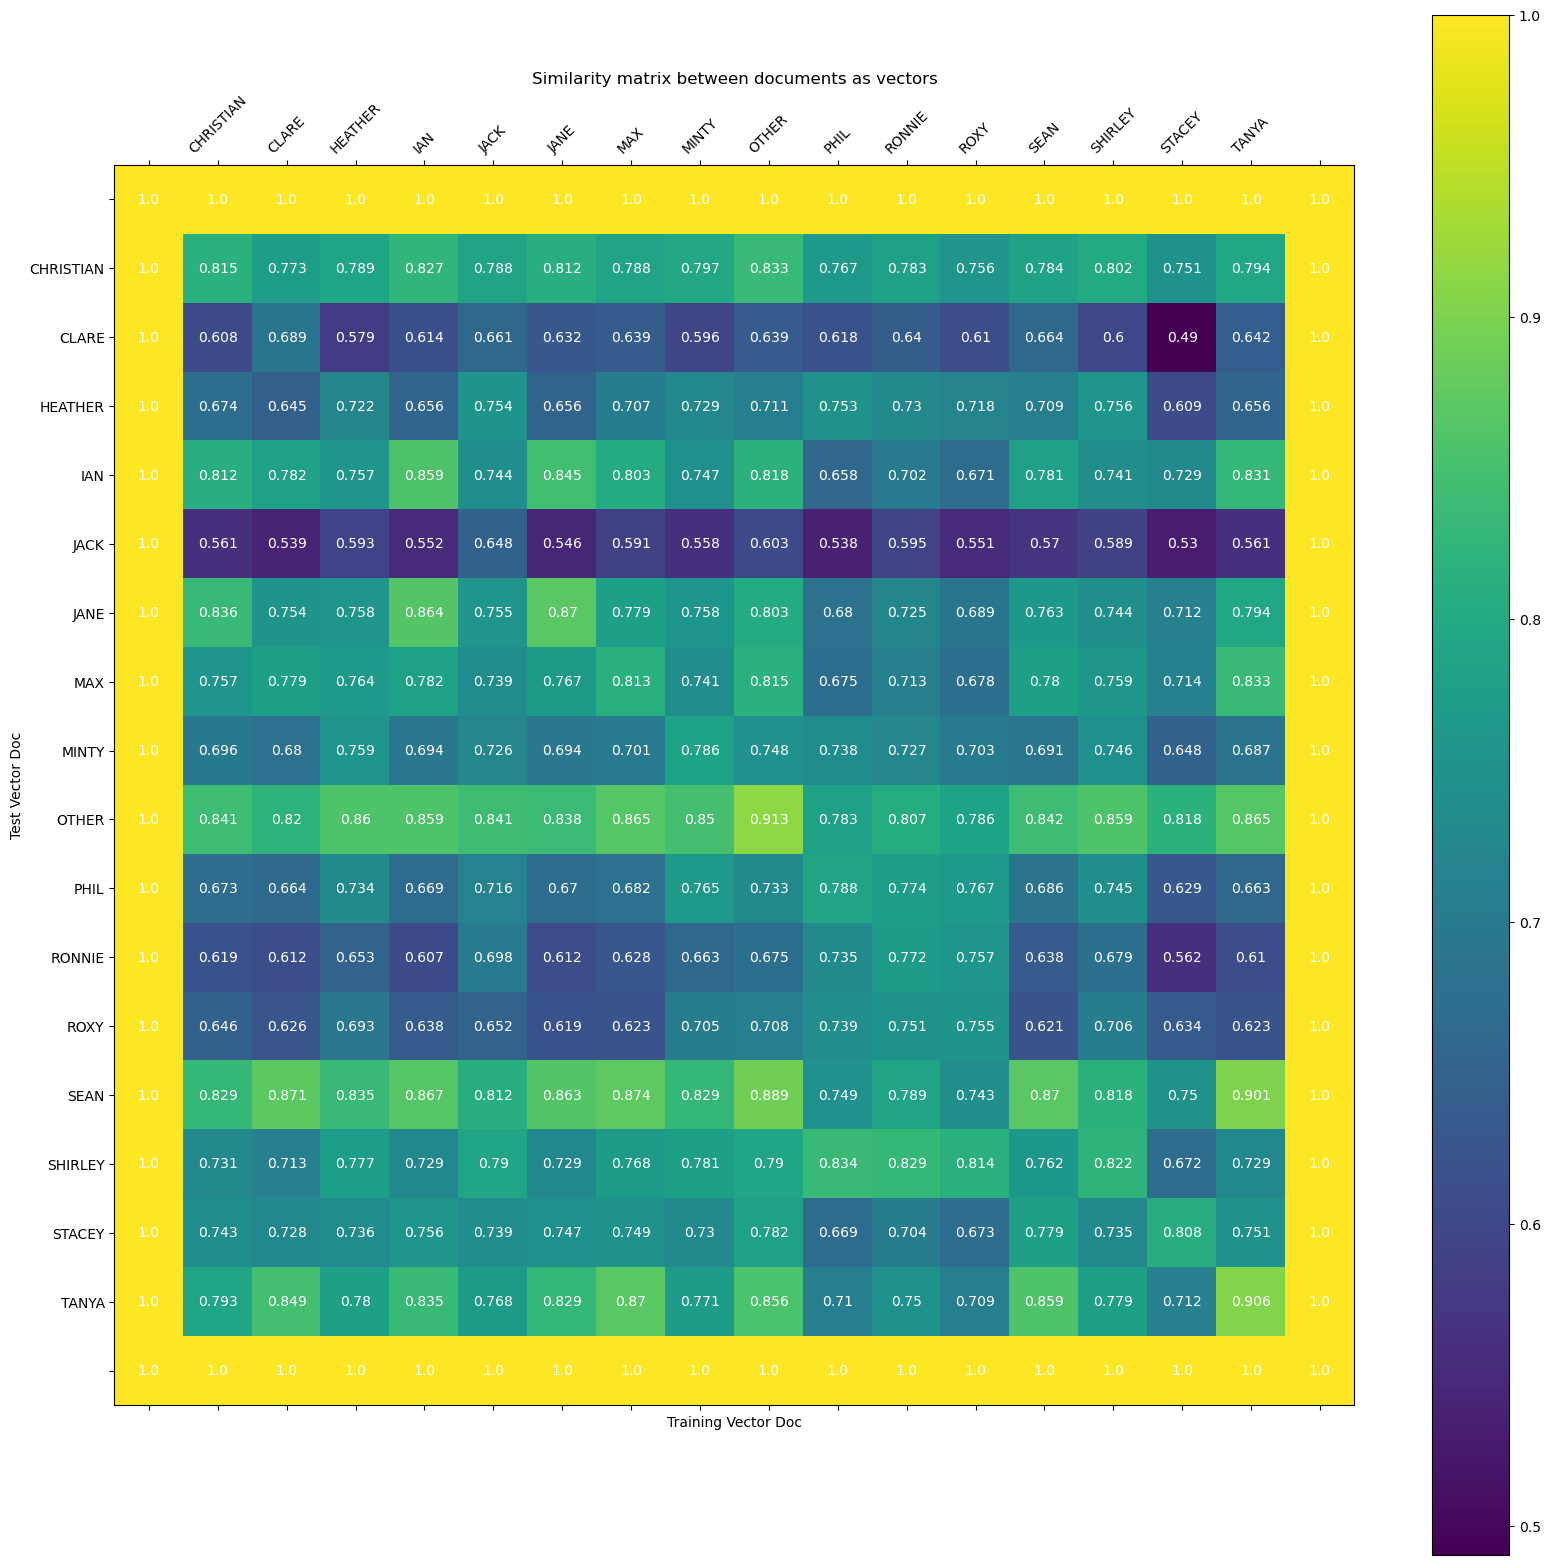

In [ ]:
plot_heat_map_similarity(df)

In [ ]:
# redo on all training data with the first 400 character lines used
train_character_docs = create_character_document_from_dataframe(all_train_data, max_line_count=400)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in train_character_docs.items()]
train_labels = [name for name, doc in training_corpus]

corpusVectorizer = TfidfVectorizer(ngram_range = (1,1),stop_words='english')   # initialize a corpusVectorizor which will output sparse vectors from dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=40)
print('Num. Characters: ',len(test_character_docs.keys()),"\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ',len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character) 
test_corpus = [(name, pre_process(doc)) for name, doc in test_character_docs.items()]
test_labels = [name for name, doc in test_corpus]


# Just transform the val_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)


mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)

lines per character {'CHRISTIAN': 95, 'CLARE': 100, 'HEATHER': 114, 'IAN': 191, 'JACK': 129, 'JANE': 157, 'MAX': 156, 'MINTY': 111, 'OTHER': 400, 'PHIL': 123, 'RONNIE': 130, 'ROXY': 109, 'SEAN': 118, 'SHIRLEY': 129, 'STACEY': 129, 'TANYA': 254}
Num. Characters:  16 

CHRISTIAN Number of Words:  12888
CLARE Number of Words:  11861
HEATHER Number of Words:  14863
IAN Number of Words:  25055
JACK Number of Words:  15938
JANE Number of Words:  21176
MAX Number of Words:  18293
MINTY Number of Words:  15861
OTHER Number of Words:  46197
PHIL Number of Words:  17064
RONNIE Number of Words:  14674
ROXY Number of Words:  12696
SEAN Number of Words:  11221
SHIRLEY Number of Words:  15957
STACEY Number of Words:  15316
TANYA Number of Words:  28727
total words 297787
lines per character {'CHRISTIAN': 13, 'CLARE': 11, 'HEATHER': 14, 'IAN': 22, 'JACK': 13, 'JANE': 16, 'MAX': 19, 'MINTY': 14, 'OTHER': 40, 'PHIL': 13, 'RONNIE': 13, 'ROXY': 12, 'SEAN': 15, 'SHIRLEY': 19, 'STACEY': 16, 'TANYA': 28}
Nu

# Conclusion
After testing we obtained a mean rank of 1.18 with a cosine similarity of 0.82
and an accuracy score of 81 percent. We were able to correct predict 13 out of 16 characters.